In [9]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix,recall_score,f1_score,r2_score,precision_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


### Define the following functions as per the description, so that they can be called later to perform the tasks.

In [10]:
# Remove correlated features

def remove_corelated_features(X_train,val):
    """ Function to remove the correlated features
    
    This function accepts the dataframe X_train,val which creates a correlation matix and removes 
    the correlated features based on certain threshold.
    
    Keyword arguments:
    X_train - Pandas dataframe which contains the independent features.
    val - Certain threshold value by which correlated features to be dropped.
    to_drop - Columns to be dropped
    
    """
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > val)]
    X_train.drop(to_drop,axis=1)
    
    return X_train.drop(to_drop,axis=1)



In [11]:
# check the distribution of the passed features
    
def cal_eval_metric(y_test, y_pred, metric):
    """  Check the distribution of the passed features
    
    This function will check for the metric passed(accuracy/precision/recall/f1) 
    and return the required value.
    
    Keyword Arguments:   
    y_test: actual target values
    y_pred: predicted target values
    metric: the metric to be calculated
    
    Return:
    score - Calculated Evaluation Score
    
    """
    if metric == 'accuracy':
        score = round(accuracy_score(y_test,y_pred),2)
    elif metric == 'precision':
        score = round(precision_score(y_test,y_pred),2)
    elif metric == 'recall':
        score = round(recall_score(y_test,y_pred),2)
    elif metric == 'f1':
        score = round(f1_score(y_test,y_pred),2)
    elif metric == 'r2':
        score = round(r2_score(y_test,y_pred),2)
    else:
        print("Invalid metric") 
    
    return score



### Read the dataset. Take a look at the dataset. 

* Check the data types present in the dataframe.
* Call the num_and_cat_columns() with train as the parameter and store the results.
* Are there any missing values? Are there any Outliers? How do you want to treat them?


In [20]:
# Code starts here

train = pd.read_csv('train.csv')
print(train.head())
print(train.shape)
print(train.info())

# Code ends here

   Id  loan_amnt  funded_amnt  term  int_rate  installment  grade  emp_title  \
0   0    27000.0      27000.0     1       141       805.68      6     100315   
1   1    15000.0      15000.0     0        77       551.36      3      94083   
2   2     7000.0       7000.0     0         8       222.28      0      64843   
3   3    18950.0      18950.0     0        38       648.50      1      54947   
4   4    35000.0      35000.0     1       108       976.04      4      56326   

   home_ownership  annual_inc  ...  total_rec_late_fee  recoveries  \
0               4    120000.0  ...                 0.0         0.0   
1               0    100000.0  ...                 0.0         0.0   
2               0     48000.0  ...                 0.0         0.0   
3               4     54000.0  ...                 0.0         0.0   
4               0     87000.0  ...                 0.0         0.0   

   collection_recovery_fee  last_pymnt_amnt  collections_12_mths_ex_med  \
0                      

In [21]:
print(train.skew())

Id                              0.000000
loan_amnt                       0.707643
funded_amnt                     0.707773
term                            1.238909
int_rate                        0.803100
installment                     0.918088
grade                           0.723094
emp_title                      -0.162601
home_ownership                  0.114697
annual_inc                     26.404882
verification_status            -0.303215
purpose                         2.649626
title                           0.610231
zip_code                       -0.058435
addr_state                      0.083644
dti                             0.127931
delinq_2yrs                     5.397228
inq_last_6mths                  1.442369
open_acc                        0.986863
pub_rec                        23.312972
revol_bal                      31.052149
revol_util                     -0.333148
total_acc                       0.762259
total_rec_late_fee             16.631272
recoveries      

### Visualize the data

- Check for the categorical & continuous features. 
- Check out the best plots for plotting between categorical target and continuous features and try making some inferences from these plots.
- Clean the data and apply some data preprocessing techniques

In [22]:
# Code starts here
# choose categorical and continuous features from data

categorical_columns = [c for c in train.columns 
                       if train[c].dtype.name == 'object']
numerical_columns = [c for c in train.columns 
                     if train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

# Code ends here

categorical_columns: []
numerical_columns: ['Id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'loan_status']


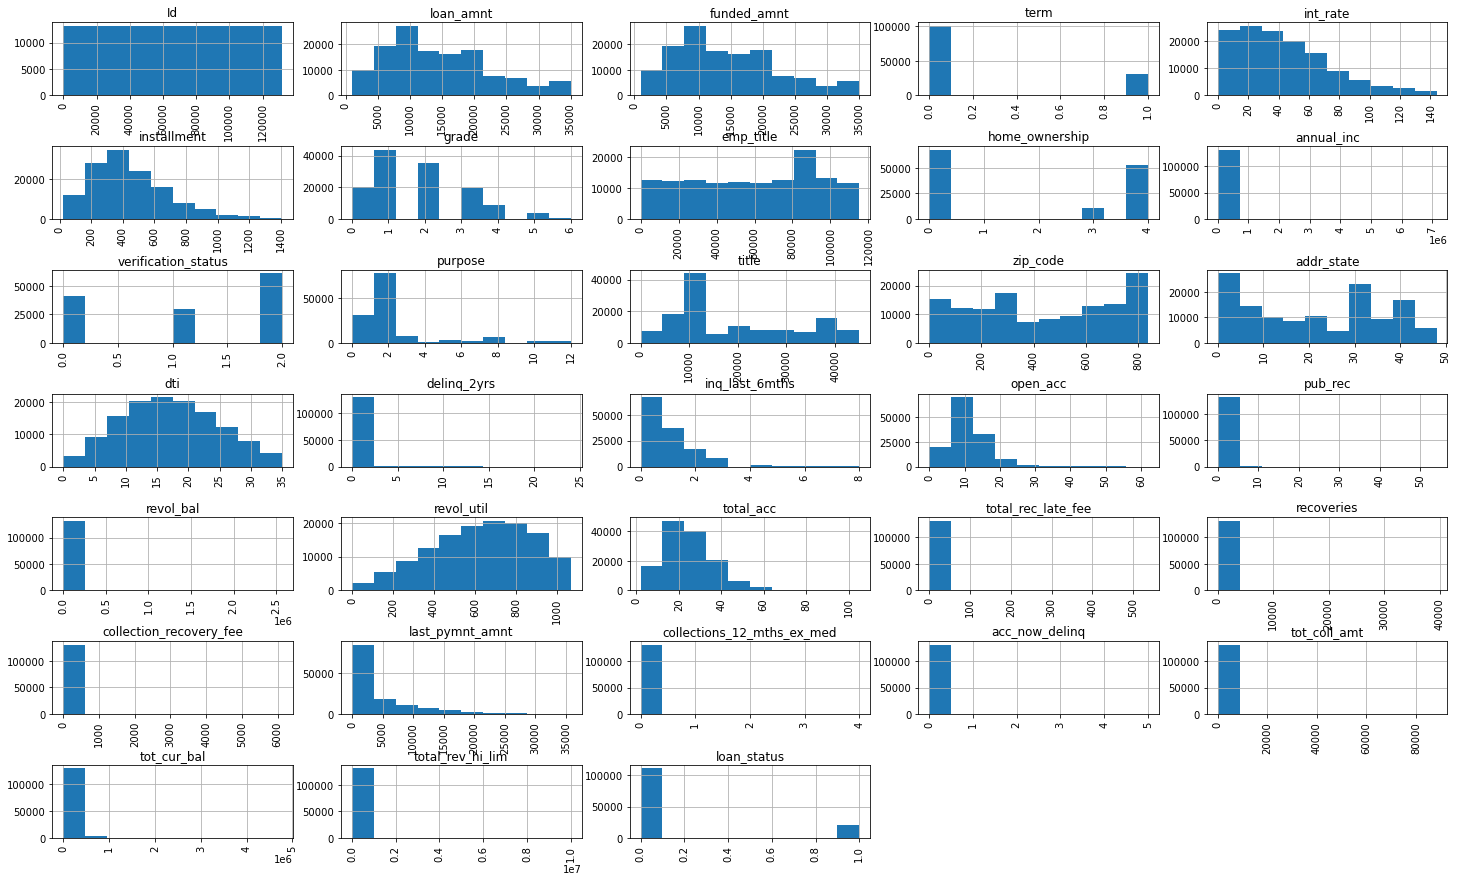

In [23]:
# Code starts here

fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(train.shape[1]) / cols)
for i, column in enumerate(train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if train.dtypes[column] == np.object:
        train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Code ends here.

### Model building

- Separate the features and target and then split the train data into train and validation set.
- Now let's come to the actual task, using linear regression, predict the `Total Compensation`. 
- Try improving upon the `r2_score` (R-Square) using different parameters that give the best score.



In [24]:
# Code starts here
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=0)
X_train = remove_corelated_features(X_train,0.50)
X_val = remove_corelated_features(X_val,0.50)

# Code ends here

In [25]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_val)

f1 = cal_eval_metric(y_val,y_train_pred,'f1')
r2 = cal_eval_metric(y_val,y_train_pred,'r2')
print("Accuracy score:",model.score(X_train,y_train))
print("f1-score:",f1)
print("r2 score:",r2)

Accuracy score: 0.955026082052728
f1-score: 0.83
r2 score: 0.66


In [26]:
params = {'C':[0.1,0.5,1,5]}

grid_search = GridSearchCV(estimator=model, param_grid=params)
grid_search.fit(X_train,y_train)
y_pred_grid_search = grid_search.predict(X_val)
f1 = cal_eval_metric(y_val,y_pred_grid_search,'f1')
r2 = cal_eval_metric(y_val,y_pred_grid_search,'r2')
print("Accuracy score:",model.score(X_train,y_train))
print("f1-score:",f1)
print("r2 score:",r2)

Accuracy score: 0.955026082052728
f1-score: 0.83
r2 score: 0.66


In [27]:
model = RandomForestClassifier(n_estimators=100,random_state=8,n_jobs=4)
rfe = RFE(model, 42)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_val)
model.fit(X_train_rfe,y_train)
y_pred_rfe = model.predict(X_test_rfe)
f1 = cal_eval_metric(y_val,y_pred_rfe,'f1')
r2 = cal_eval_metric(y_val,y_pred_rfe,'r2')
print("Accuracy score:",model.score(X_train,y_train))
print("f1-score:",f1)
print("r2 score:",r2)

Accuracy score: 1.0
f1-score: 0.96
r2 score: 0.92


### Prediction on the test data and creating the sample submission file.

- Load the test data and store the `Id` column in a separate variable.
- Perform the same operations on the test data that you have performed on the train data.
- Create the submission file as a `csv` file consisting of the `Id` column from the test data and your prediction as the second column.

In [28]:
# Code starts here
# Read the test data
test = pd.read_csv("test.csv")
test = remove_corelated_features(test,0.50)
# Storing the id from the test file
Id = test['Id']

# Predict on the test data
y_pred_test = model.predict(test)

final_submission = pd.DataFrame({'Id':Id,'loan_status':y_pred_test})

# Convert the sample submission file into a csv file
final_submission.to_csv('final_submission.csv',index=False)

# Code ends here